In [1]:
%load_ext lab_black

import numpy as np
import pandas as pd
import glob
import os
import matplotlib.transforms as mtrans
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import SpectralCoclustering
import itertools
import matplotlib

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

In [2]:
def plot_heatmap(
    df,
    df_annot=None,
    annot_kws=None,
    cmap="RdBu_r",
    dpi=150,
    squaresize=20,
    heatmap_linewidths=0.5,
    heatmap_linecolor="gray",
    heatmap_xticklabels=True,
    heatmap_yticklabels=True,
    heatmap_cbar=True,
    heatmap_cbar_kws=dict(use_gridspec=False, location="top", fraction=0.03, pad=0.01),
    heatmap_vmin=-5,
    heatmap_vmax=5,
    xticklabels_rotation=45,
    colormap_n_bin=10,
):
    figwidth = df.shape[1] * squaresize / float(dpi)
    figheight = df.shape[0] * squaresize / float(dpi)
    fig, ax = plt.subplots(1, figsize=(figwidth, figheight), dpi=dpi)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    sns.heatmap(
        df,
        cmap=cmap,
        linewidths=heatmap_linewidths,
        linecolor=heatmap_linecolor,
        square=True,
        annot=df_annot,
        annot_kws=annot_kws,
        fmt="",
        ax=ax,
        xticklabels=heatmap_xticklabels,
        yticklabels=heatmap_yticklabels,
        cbar=heatmap_cbar,
        cbar_kws=heatmap_cbar_kws,
        vmin=heatmap_vmin,
        vmax=heatmap_vmax,
    )

    plt.yticks(fontsize=8)
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=xticklabels_rotation,
        va="top",
        ha="right",
        fontsize=8,
    )
    ax.tick_params(left=False, bottom=False, pad=-2)
    trans = mtrans.Affine2D().translate(5, 0)
    for t in ax.get_xticklabels():
        t.set_transform(t.get_transform() + trans)
    return fig, ax

In [3]:
df_baseline = pd.read_csv("out/baseline_r2.tsv", sep="\t", index_col=0)["baseline_r2"]

# read R2 diff and p-values
df_tmp = pd.read_csv("out/r2_diff.tsv", sep="\t")
df_tmp["std_r2_diff"] = df_tmp.apply(lambda r: r.r2_diff / df_baseline[r.trait], axis=1)

df_diff = df_tmp.pivot(index="test_col", columns="trait", values="std_r2_diff")
df_diff_pval = df_tmp.pivot(index="test_col", columns="trait", values="prob>0")
df_diff_pval = df_diff_pval.applymap(lambda x: 2 * min(x, 1 - x))
df_diff, df_diff_pval = (
    df_diff[df_baseline.index.values],
    df_diff_pval[df_baseline.index.values],
)

# p-value are wrongly assigned for some trait, cov pair with 0 R2 difference
df_diff_pval[df_diff == 0] = 1.0

assert np.all(df_baseline.index == df_diff.columns)
assert np.all(df_baseline.index == df_diff_pval.columns)

# select trait based on baseline R2 > 0.05, and at least one test covariate < 0.05
trait_list = df_baseline.index[(df_baseline > 0.05) & (df_diff_pval < 0.05).any(axis=0)]
df_diff = df_diff.loc[:, trait_list]
df_diff_pval = df_diff_pval.loc[:, trait_list]

In [4]:
plot_trait_list = (
    df_diff.abs().max(axis=0).sort_values(ascending=False).iloc[0:20].index
)

In [5]:
df_diff_plot = df_diff[plot_trait_list]
df_pval_plot = df_diff_pval[plot_trait_list]
df_annot = pd.DataFrame("", index=df_diff_plot.index, columns=df_pval_plot.columns)
for r in df_diff_plot.index:
    for c in df_diff_plot.columns:
        diff, pval = df_diff_plot.loc[r, c], df_pval_plot.loc[r, c]
        if pval < 0.05 / df_pval_plot.size:
            annot = f"{diff * 100:+.0f}%"
        elif pval < 0.05:
            annot = "*"
        else:
            annot = ""
        df_annot.loc[r, c] = annot

In [6]:
ytick_map = {
    "AGE_Q": "Age",
    "DEPRIVATION_INDEX_Q": "Deprivation index",
    "PC1_Q": "PC1",
    "PC2_Q": "PC2",
    "SEX": "Sex",
    "glasses": "Wear glasses",
    "income_Q": "Income",
    "years_of_edu_Q": "Edu years",
}

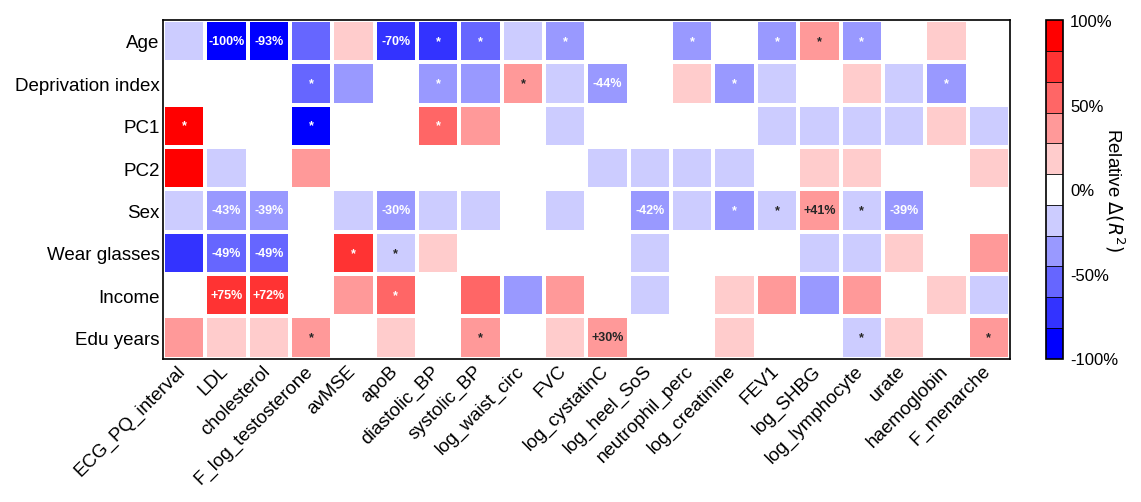

In [18]:
fig, ax = plot_heatmap(
    df_diff_plot,
    df_annot,
    annot_kws={"fontsize": 6, "weight": "bold"},
    cmap=plt.get_cmap("bwr", 11),
    squaresize=45,
    heatmap_vmin=-1.0,
    heatmap_vmax=1.0,
    heatmap_linecolor="white",
    heatmap_linewidths=1.0,
    heatmap_cbar_kws=dict(
        use_gridspec=False,
        location="right",
        fraction=0.0188,
        pad=0.04,
        drawedges=True,
    ),
)
ax.set_xlabel(None)
ax.set_xticklabels([x.get_text() for x in ax.get_xticklabels()], fontsize=9)

ax.set_ylabel(None)
ax.set_yticklabels([ytick_map[y.get_text()] for y in ax.get_yticklabels()], fontsize=9)

cbar = ax.collections[0].colorbar
cbar.set_ticks([-1, -0.5, 0, 0.5, 1.0])
cbar.set_ticklabels(["-100%", "-50%", "0%", "50%", "100%"])
cbar.ax.set_ylabel("Relative $\Delta (R^2)$", rotation=270, fontsize=9)
cbar.outline.set_edgecolor("black")
cbar.outline.set_linewidth(0.8)

cbar.ax.tick_params(labelsize=8)
cbar.ax.tick_params(size=0)

for _, spine in ax.spines.items():
    spine.set_visible(True)

fig.savefig("results/heatmap.pdf", bbox_inches="tight")
fig.show()